In [2]:
%%capture
# special kaggle workspace command

!pip install transformers

In [3]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt

from transformers import pipeline

2024-07-11 09:53:57.900432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 09:53:57.900567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 09:53:58.072180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# change to your folder with data
MODEL_PATH = '/kaggle/input/train-model-for-sentiment-analysis/sentiment_analysis_reviews_model/checkpoint-37500'
ORDER_REVIEWS_PATH = '/kaggle/input/test-assigment-smart-it/order_reviews.csv'

# Load model

This is my trained model for sentiment analysis. It was trained about 4 hours on GPU P100 in free code workspace.

I dont find either portuguese model or dataset, thats why I decided to use multilingual model and tune on english dataset. Definetely, results are not all correct. I chose this approach only because its faster. Another more accurate approach was to translate reviews to english and use tuned english sentiment analysis model. Its slower, so if its needed to process all data from table, approximate translating of this table would take +- 15 hours (translate one string takes about 1s) 
<br>
English sentiment analysis model on huggingface: 'AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon'.

Huggingface dataset is 'fancyzhx/amazon_polarity' I used 400,000 entries. 
<br>
Tuned model is 'google-bert/bert-base-multilingual-cased' 

In [28]:
classifier = pipeline(
    "sentiment-analysis",
    model=MODEL_PATH
)

In [29]:
print(classifier('Eu comprei duas unidades e só recebi uma e agora o que faço?'))
print(classifier('GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU'))

[{'label': 'NEGATIVE', 'score': 0.9429442286491394}]
[{'label': 'POSITIVE', 'score': 0.9677936434745789}]


In [30]:
print(classifier('muito lindo,'))
print(classifier('MUITO lindo,'))
print(classifier('MT lindo,MT lindo,'))

[{'label': 'POSITIVE', 'score': 0.9915392994880676}]
[{'label': 'POSITIVE', 'score': 0.9064427018165588}]
[{'label': 'POSITIVE', 'score': 0.8215622901916504}]


# Load order_reviews.csv

In [5]:
order_reviews = pd.read_csv(ORDER_REVIEWS_PATH)

In [32]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

# Classify reviews

In [33]:
def classify_sentence(s):
    classification = classifier(s)[0]
        
    if classification['score'] < 0.75:
        return 'NEUTRAL'
    else:
        return classification['label']

    
# NaN or empty reviews are not classified. In column will be '' empty string
def classify_reviews(df):
    df_c = df.copy()
    df_c[['review_comment_title', 'review_comment_message']] = df_c[
        ['review_comment_title', 'review_comment_message']].fillna(value='')
    
    review_comment_titles = list(df_c['review_comment_title'])
    review_comment_messages = list(df_c['review_comment_message'])
    
    classified_comments = []
    
    i = 0
    for title, message in zip(review_comment_titles, review_comment_messages):
        i += 1
        if i % 5000 == 0:
            print(f"Iterated {i} comments")
        
        full_comment = ''
        is_title_empty = title.strip() == '' 
        is_comment_empty = message.strip() == ''
        
        if is_title_empty and is_comment_empty:
            classified_comments.append('')
            continue
        elif is_title_empty and not is_comment_empty:
            full_comment = message
        elif not is_title_empty and is_comment_empty:
            full_comment = title
        elif not is_title_empty and not is_comment_empty:
            full_comment = title + '. ' + message
        
        classified_comment = classify_sentence(full_comment)
        classified_comments.append(classified_comment)
    
    df_c['classified_title_message'] = classified_comments
    return df_c

In [11]:
# 100,000 length df takes about 1 hour
classified_data = classify_reviews(order_reviews)

# save data to current folder
classified_data.to_csv('classified_order_reviews.csv')

classified_data.tail()

Iterated 5000 comments
Iterated 10000 comments
Iterated 15000 comments
Iterated 20000 comments
Iterated 25000 comments
Iterated 30000 comments
Iterated 35000 comments
Iterated 40000 comments
Iterated 45000 comments
Iterated 50000 comments
Iterated 55000 comments
Iterated 60000 comments
Iterated 65000 comments
Iterated 70000 comments
Iterated 75000 comments
Iterated 80000 comments
Iterated 85000 comments
Iterated 90000 comments
Iterated 95000 comments
Iterated 100000 comments


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,classified_title_message
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,,,2017-12-09 00:00:00,2017-12-11 20:06:42,
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,POSITIVE
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,,,2018-07-01 00:00:00,2018-07-02 12:59:13,
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43,NEGATIVE
99999,efe49f1d6f951dd88b51e6ccd4cc548f,90531360ecb1eec2a1fbb265a0db0508,1,,"meu produto chegou e ja tenho que devolver, po...",2017-07-03 00:00:00,2017-07-03 21:01:49,NEGATIVE


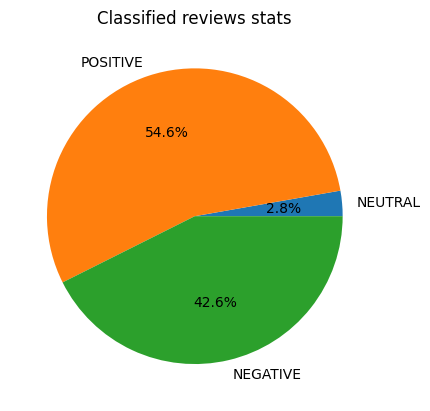

In [21]:
classified_counts = classified_data['classified_title_message'].value_counts()


fig, ax = plt.subplots()

ax.pie([classified_counts['NEUTRAL'], classified_counts['POSITIVE'], classified_counts['NEGATIVE']],
       labels=['NEUTRAL', 'POSITIVE', 'NEGATIVE'],
       autopct='%1.1f%%')
ax.set(title='Classified reviews')

plt.show()

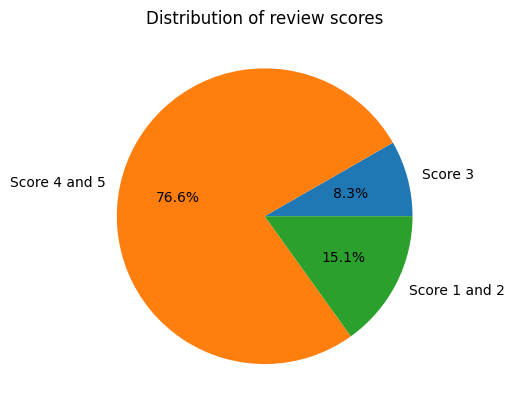

In [22]:
scores = classified_data['review_score'].value_counts()


fig, ax = plt.subplots()

ax.pie([scores[3], scores[4] + scores[5], scores[1] + scores[2]],
       labels=['Score 3', 'Score 4 and 5', 'Score 1 and 2'],
       autopct='%1.1f%%')
ax.set(title='Distribution of review scores')

plt.show()

# Find price in reviews

As I was looking for trained NER model, that can highlight price entity. I did not find good model especially for portuguese. Also I didnt find portuguese NER dataset to train model.

Another idea was to create dataset with reviews from order_reviews.csv and train model. 
I made function to parse strings for creating my dataset. I was trying 'spacy' library to train model, however it doesnt appear to show better results than my parse function. So I decide to leave my function, its uses different patterns.

In [59]:
def find_price(sentence):
    """
    Takes string.
    Returns list with matches.
    A match is a tuple which looks like this
    (start of match in string, end position, actual match string)
    """
    
    patterns = [
        '[rR]\$\s?[0-9]+([\.\,]?[0-9]+)(\s?\$)?',
        '[0-9]+([\.\,]?[0-9]+)((\s?[rR]\s?\$)|(\s?[rR]\s)|(\s?\$))',
        '[rR]\$',
        '\$',    
        '[rR]eal brasileiro',  
        '[Pp]reço[s]?',   
        'USD',
        'usd',
        'BRL',
        'brl',
        'dólar(es)? americano?',
        '[cC]usto', 
        '[dD]espesa',
        '[vV]alor'
    ]

    pattern = re.compile('|'.join(patterns))

    matches = []
    
    for m in pattern.finditer(sentence):
        matches.append((m.start(), m.end(), m.group()))
    
    return matches

In [60]:
find_price('12.77$, bom valor, 12.0 R$')

[(0, 6, '12.77$'), (12, 17, 'valor'), (19, 26, '12.0 R$')]

In [42]:
found_prices = []

for i, r in order_reviews.iterrows():
    full_review = str(r['review_comment_title']) + str(r['review_comment_message'])
    
    matches = find_price(full_review)
    
    if len(matches) == 0:
        continue
        
    found_prices.append((i, matches))

In [56]:
print(f'Number of reviews with mentioned price in title and message: {len(found_prices)}')

Number of reviews with mentioned price in title and message: 1247


In [61]:
# indexes and list of mathces found in the table
found_prices[:5]

[(12, [(33, 38, 'valor')]),
 (64, [(86, 91, 'custo')]),
 (115, [(68, 76, 'R$ 25,00'), (181, 189, 'R$ 35,90')]),
 (159, [(9, 14, 'custo')]),
 (515, [(64, 69, 'preço')])]